In [34]:
import numpy as np
import pandas as pd

from astropy import coordinates
from astropy.coordinates import match_coordinates_sky
import astropy.units as u
import astroquery
from astroquery.irsa import Irsa
from astroquery.vizier import Vizier
from astropy.table import Table, join

Irsa.ROW_LIMIT = -1
Vizier.ROW_LIMIT = -1

import matplotlib.pyplot as plt

%matplotlib inline

# Get the data

2MASS => effective resolution of the 2MASS system is approximately 5"

WISE => 3.4, 4.6, 12, and 22 μm (W1, W2, W3, W4) with an angular resolution of 6.1", 6.4", 6.5", & 12.0" 

GALEX imaging => Five imaging surveys in a Far UV band (1350—1750Å) and Near UV band (1750—2800Å) with 6-8 arcsecond resolution (80% encircled energy) and 1 arcsecond astrometry, and a cosmic UV background map.

In [35]:
obj = ["PKS J0006-0623", 1.55789, -6.39315, 1]
# name, ra, dec, radius of cone
obj_name = obj[0]
obj_ra   = obj[1]
obj_dec  = obj[2]
cone_radius  = obj[3]

In [36]:
obj_coord = coordinates.SkyCoord(ra=obj_ra, dec=obj_dec, unit=(u.deg, u.deg), frame="icrs")

In [37]:
data_2mass = Irsa.query_region(obj_coord, catalog="fp_psc", radius=cone_radius * u.deg)
data_wise  = Irsa.query_region(obj_coord, catalog="allwise_p3as_psd", radius=cone_radius * u.deg)
__data_galex = Vizier.query_region(obj_coord, catalog='II/335', radius=cone_radius * u.deg)
data_galex = __data_galex[0]

In [38]:
num_2mass = len(data_2mass)
num_wise  = len(data_wise)
num_galex = len(data_galex)

print("Number of object in (2MASS, WISE, GALEX): ", num_2mass, num_wise, num_galex)

Number of object in (2MASS, WISE, GALEX):  4802 38322 10105


# Matching coordinates

In [60]:
# use only coordinate columns
ra_2mass = data_2mass['ra']
dec_2mass = data_2mass['dec']
c_2mass = coordinates.SkyCoord(ra=ra_2mass, dec=dec_2mass, unit=(u.deg, u.deg), frame="icrs")

ra_wise  = data_wise['ra']
dec_wise = data_wise['dec']
c_wise = coordinates.SkyCoord(ra=ra_wise, dec=dec_wise, unit=(u.deg, u.deg), frame="icrs")

ra_galex  = data_galex['RAJ2000']
dec_galex = data_galex['DEJ2000']
c_galex = coordinates.SkyCoord(ra=ra_galex, dec=dec_galex, unit=(u.deg, u.deg), frame="icrs")

In [61]:
####
sep_min = 6.0 * u.arcsec # minimum separation in arcsec

In [62]:
# Only 2MASS and WISE matching 
#
idx_2mass, idx_wise, d2d, d3d = c_wise.search_around_sky(c_2mass, sep_min)
# select only one nearest if there are more in the search reagion (minimum seperation parameter)!

print("Only 2MASS and WISE: ", len(idx_2mass))

Only 2MASS and WISE:  4660


# Plot W1-J vs W1

In [63]:
# from matching of 2 cats (2MASS and WISE) coordinate
w1 = data_wise[idx_wise]['w1mpro']
j = data_2mass[idx_2mass]['j_m']
w1j = w1-j

# match between WISE and 2MASS
data_wise_matchwith_2mass = data_wise[idx_wise] # WISE dataset

cutw1j = -1.7

galaxy = data_wise_matchwith_2mass[w1j < cutw1j] # https://academic.oup.com/mnras/article/448/2/1305/1055284

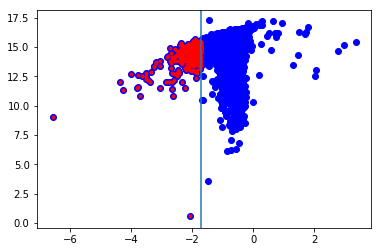

In [64]:
w1j_galaxy = w1j[w1j<cutw1j]
w1_galaxy = w1[w1j<cutw1j]

plt.scatter(w1j, w1, marker='o', color='blue')
plt.scatter(w1j_galaxy, w1_galaxy, marker='.', color="red")
          
plt.axvline(x=cutw1j) # https://academic.oup.com/mnras/article/448/2/1305/1055284

- W1-J < -1.7 => galaxy
- W1-J > -1.7 => stars

only 2 object are galaxy?

In [65]:
# GALEX
###
# coord of object in 2mass which match wise (first objet/nearest in sep_min region)
c_2mass_matchwith_wise = c_2mass[idx_2mass]
c_wise_matchwith_2mass = c_wise[idx_wise]

#Check with 2mass cut
idx_2mass_wise_galex, idx_galex1, d2d, d3d = c_galex.search_around_sky(c_2mass_matchwith_wise, sep_min)
num_galex1 = len(idx_galex1)
#Check with wise cut
idx_wise_2mass_galex, idx_galex2, d2d, d3d = c_galex.search_around_sky(c_wise_matchwith_2mass, sep_min)
num_galex2 = len(idx_galex2)

print("Number of match in 2MASS cut (with WISE): ", num_galex1)
print("Number of match in WISE cut (with 2MASS): ", num_galex2)

# diff/average
print("Confusion level: ", abs(num_galex1 - num_galex2)/np.mean([num_galex1, num_galex2])*100, "%")

Number of match in 2MASS cut (with WISE):  1548
Number of match in WISE cut (with 2MASS):  1557
Confusion level:  0.5797101449275363 %


# Filter all Cats

In [66]:
# Choose which one is smaller!
if num_galex1 < num_galex2:
    select_from_galex = idx_galex1
else:
    select_from_galex = idx_galex2

print(len(select_from_galex))
match_galex = data_galex[select_from_galex]
c_selected_galex = c_galex[select_from_galex]

# Select other catalog using GALEX again
# 2MASS
idx_2mass, idx_galex1, d2d, d3d = c_2mass.search_around_sky(c_selected_galex, sep_min)

# WISE
idx_wise, idx_galex2, d2d, d3d = c_wise.search_around_sky(c_selected_galex, sep_min)


print("Number of match in GALEX: ", len(c_selected_galex))
print("Number of match in 2MASS: ", len(idx_2mass))
print("Number of match in WISE : ", len(idx_wise))

1548
Number of match in GALEX:  1548
Number of match in 2MASS:  1626
Number of match in WISE :  1612
